<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Measurement Error and Mitigation*_ 


***
### Contributors
David McKay and Yael Ben-Haim

## Introduction

The last step of a typical quantum experiment is to perform a measurement on the qubits in the circuit. Although the qubit state $|\Psi\rangle$ (or more generally the density matrix $\rho$) is the general description of the quantum state, in a typical strong projective measurement our measurement _projects_ the general state into a specific computational state $|x\rangle$ (where $x$ is a bitstring, e.g.,  `1001010`) The probability of measuring bitstring $x$ is given by:
$$P_x = \mathrm{Trace}(\langle x|\rho|x \rangle)$$
Therefore, the measurement process is stochastic. The above distribution of $x$ given a state $\rho$ is true only in the absence of measurement errors. There are multiple sources of possible measurement error, all of which are dependent on the physical mechanism of measurement in the system. For superconducting qubits coupled to readout cavities [[1](#ref1),[2](#ref2),[3](#ref3),[4](#ref4),[5](#ref5)] the state of the qubit is determined by measurement the response of a microwave tone incident on the readout cavity. The cavity signal is measured for some time where $V(t)$ is the complex amplitude of the signal which is converted to a single complex number based on a measurement kernel 
$$V = \int_0^{T} V(t) K(t) dt $$
which is then turned into a _bit_ by a nonlinear discriminator [[6](#ref6)]. The simplest example being if $|V|<V_0$ then the qubit was in state 0 and otherwise the qubit was in state 1. 

As discussed in [[6](#ref6)] there are classical sources of noise on the signal that lead to misidentification of the qubit state, but it can also happen that the qubit decays due to $T_1$ during the measurement. There are other sources of crosstalk (to numerous to enumerate) such as classical crosstalk on the lines and crosstalk between resonantors on chip. All of these issues lead to a new probability distribution $\tilde{P}_{\rho}$ for a given state. Given certain assumptions about these errors and appropriate calibration we can attempt to correct the skew in the probability distribution _on average_. 

**Contents**

[Constructing a Full Calibration Matrix](#sect1)

[Correcting Results with the Calibration Matrix](#sect2)


### References

[1]<a id="ref1"></a> Alexandre Blais, Ren-Shou Huang, Andreas Wallraff, S. M. Girvin, and R. J. Schoelkopf, Cavity quantum electrodynamics for superconducting electrical circuits: An architecture for quantum computation, https://arxiv.org/abs/cond-mat/0402216

[2]<a id="ref2"></a> Jay Gambetta, Alexandre Blais, D. I. Schuster, A. Wallraff, L. Frunzio, J. Majer, M. H. Devoret, S. M. Girvin, and R. J. Schoelkopf. Qubit-photon interactions in a cavity: Measurement induced dephasing and number splitting
https://arxiv.org/abs/cond-mat/0602322 

[3]<a id="ref3"></a> Alexandre Blais, Jay Gambetta, A. Wallraff, D. I. Schuster, S. M. Girvin, M. H. Devoret, and R. J. Schoelkopf. Quantum information processing with circuit quantum electrodynamics. https://arxiv.org/abs/cond-mat/0612038

[4]<a id="ref4"></a> Jay Gambetta, W. A. Braff, A. Wallraff, S. M. Girvin, R. J. Schoelkopf. Protocols for optimal readout of qubits using a continuous quantum nondemolition measurement. https://arxiv.org/abs/cond-mat/0701078

[5]<a id="ref5"></a> Jay Gambetta, Alexandre Blais, M. Boissonneault, A. A. Houck, D. I. Schuster and S. M. Girvin. Quantum trajectory approach to circuit QED: Quantum jumps and the Zeno effect. https://arxiv.org/abs/0709.4264

[6]<a id="ref6"></a> Colm A. Ryan, Blake R. Johnson, Jay M. Gambetta, Jerry M. Chow, Marcus P. da Silva, Oliver E. Dial and Thomas A. Ohki. Tomography via Correlation of Noisy Measurement Records. https://arxiv.org/abs/1310.6448

Code imports
==============

In [8]:
# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

# Constructing a Full Calibration Matrix

The assumption of the error mitigation technique is that we can prepare each of the basis states with very low error. Given this assumption, in separate experiments we can prepare one of the $2^n$ states and then measure the outputs in all $2^n$ states ($n$ denotes the number of qubits). Normalizing these outputs and making each set of output probabilities for a given prepared state the columns of a matrix we obtain the matrix $\mathbf{A}$ which translates the ideal probability distribution of the state $\rho$ ($P_\rho$) into the experimental probability distribution $\tilde{P}_{\rho}$
$$\tilde{P}_{\rho} = \mathbf{A} \cdot P_{\rho}$$


**Code**

The code below constructs the calibration matrix for 2 qubits with error artificially put into the Aer simulation.

In [2]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1], qr=qr)
# Generate a noise model for the 2 qubits
noise_model = noise.NoiseModel()
for qi in range(2):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])
backend = qiskit.Aer.get_backend('qasm_simulator')
job_no_noise = qiskit.execute(meas_calibs, backend=backend, shots=1000)
job_w_noise = qiskit.execute(meas_calibs, backend=backend, noise_model=noise_model, shots=1000)
cal_results = job_no_noise.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
print("Ideal calibration matrix:")
print(meas_fitter.cal_matrix)
cal_results = job_w_noise.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
print("Noisy calibration matrix:")
print(meas_fitter.cal_matrix)

Ideal calibration matrix:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Noisy calibration matrix:
[[0.822 0.233 0.23  0.052]
 [0.091 0.671 0.034 0.196]
 [0.079 0.021 0.658 0.205]
 [0.008 0.075 0.078 0.547]]


We can see that with noise when we prepare the state $|11\rangle$ and measure we get counts in states other than $|11\rangle$

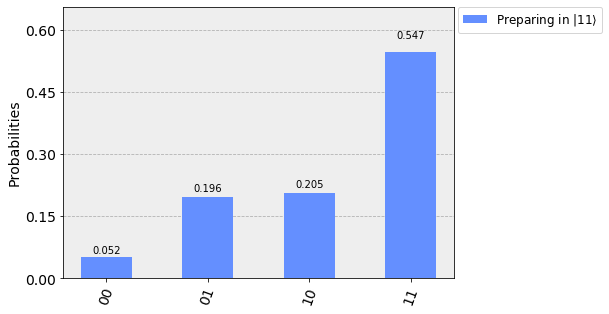

In [3]:
plot_histogram([cal_results.get_counts('cal_11')], legend=[r'Preparing in $|11\rangle$'])

# Correcting Using the Calibration Matrix

If we have the calibration matrix $\mathbf{A}$ which gives the transformation between the distributions, 
$$\tilde{P}_{\rho} = \mathbf{A} \cdot P_{\rho}$$
then to work back to $P_{\rho}$ we just need to invert $\mathbf{A}$,
$$P_{\rho} = \mathbf{A}^{-1} \cdot \tilde{P}_{\rho}$$
However, there are some issues to watch out for.

Below, we simulate a calibration with 200 shots and then prepare the state $|11\rangle$ and measure with 2000 shots. 

In [4]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1], qr=qr)
# Generate a noise model for the 2 qubits
noise_model = noise.NoiseModel()
for qi in range(2):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])
backend = qiskit.Aer.get_backend('qasm_simulator')
job_w_noise_cal = qiskit.execute(meas_calibs, backend=backend, noise_model=noise_model, shots=200)
job_for_correction = qiskit.execute(meas_calibs[-1], backend=backend, noise_model=noise_model, shots=2000)
cal_results = job_w_noise_cal.result()
raw_results = job_for_correction.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter
print("Corrected Results using Matrix Inversion:")
print(meas_filter.apply(raw_results, method='pseudo_inverse').get_counts('cal_11'))

Corrected Results using Matrix Inversion:
{'00': 78.53572288696638, '11': 2201.7356906637406, '01': -151.93989696959034, '10': -128.33151658111535}


If you run the above code several times, you will likely see some negative counts. This is because there is some statistical noise in the calibration matrix which means that the corrected results will be unphysical. To correct for this we can find the $P_{\rho}$ which is closest to reproducing the measured output,
$$\text{min}_{P_{\rho}} ||\tilde{P}_{\rho}-\mathbf{A}\cdot P_{\rho}||$$
but where all elements of $P$ are non-zero.

In [5]:
print("Corrected Results using Constrained Least Square:")
print(meas_filter.apply(raw_results).get_counts('cal_11'))

Corrected Results using Constrained Least Square:
{'10': 2.8202862267789897e-10, '11': 1999.9999999994943, '01': 3.879847554344451e-10}


# Tensored Mitigation

Tensored mitigation applies for local errors. In a fully-tensored mitigation all the errors act on a single qubit. In this case, the calibration matrix $\mathbf{A}$ has the form
$$ \mathbf{A} = \bigotimes_{i=1}^n A_i, $$
where $A_i$ is a specific calibration matrix of the $i$th qubit.

Fully-tensored mitigation requires only two calibration circuits, as opposed to $2^n$ circuits in the general case. Moreover, the calculation of the estimate of $P_{\rho}$ does not require construction of the full calibration matrix $\mathbf{A}$, thus saving the need to store an $2^n$ times $2^n$ matrix in memory; this is true for both pseudo-inverse and least-squares methods.

In [10]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(2)
mit_pattern = [[0], [1]]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr)
# Generate a noise model for the 2 qubits
noise_model = noise.NoiseModel()
for qi in range(2):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])
backend = qiskit.Aer.get_backend('qasm_simulator')
job_w_noise = qiskit.execute(meas_calibs, backend=backend, noise_model=noise_model, shots=1000)
cal_results = job_w_noise.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern)
print("Noisy calibration matrices:")
print(meas_fitter.cal_matrices)
job_for_correction = qiskit.execute(meas_calibs[-1], backend=backend, noise_model=noise_model, shots=2000)
raw_results = job_for_correction.result()
meas_filter = meas_fitter.filter
print("Corrected Results using Matrix Inversion:")
print(meas_filter.apply(raw_results, method='pseudo_inverse').get_counts('cal_11'))
print("Corrected Results using Constrained Least Square:")
print(meas_filter.apply(raw_results).get_counts('cal_11'))

Noisy calibration matrices:
[array([[0.913, 0.259],
       [0.087, 0.741]]), array([[0.903, 0.236],
       [0.097, 0.764]])]
Corrected Results using Matrix Inversion:
{'00': -19.31373762659956, '11': 1962.784662714513, '10': 14.726581663296656, '01': 41.80249324878878}
Corrected Results using Constrained Least Square:
{'10': 4.41527876713894, '11': 1965.0379811472974, '01': 30.54674008556605}
